# Chapter 4 - Training Models

# Linear Regression

compute weighted sum of input features, plus bias / intercept term

$$
\hat y = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdot \cdot \cdot + \theta_n x_n
$$

- $\hat y$ = predicted value
- $n$ = number of features
- $x_i$ = ith feature
- $\theta_j$ = jth model parameter

Vectorized form: 
$$
\hat y = h_{\theta} ({x}) = {\theta} \cdot {x}
$$

- $h_{\theta}$ = hypothesis function

Cost function: Mean squared error (MSE)

$$
\operatorname{MSE}(X, h_{\theta}) = \frac{1}{m} \sum_{i=1}^{m}{(\theta^T x^{(i)} - y^{((i)})^2}
$$

The normal equation- closed form solution that gives the best values of m and b

$$
\hat \theta = (X^T X)^{-1} X^T y
$$

Generate some linear data to play with

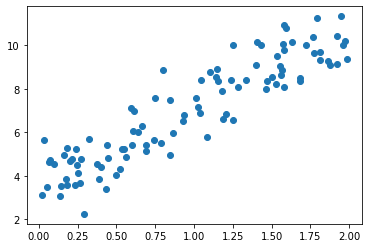

In [1]:
import numpy as np
import matplotlib.pyplot as plt

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)
plt.scatter(X, y)

Use the normal equation to get the best parameters

In [6]:
X_b = np.c_[np.ones((100, 1)), X] # add x0=1 to each instance
X_b[:5]

array([[1.        , 0.38722483],
       [1.        , 1.02313395],
       [1.        , 1.68169762],
       [1.        , 1.81090994],
       [1.        , 0.44008027]])

np.c_ takes 2 1d arrays and stacks them as columns ([doc](https://numpy.org/doc/stable/reference/generated/numpy.c_.html))

In [8]:
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[3.57786577],
       [3.52921164]])

make and plot some predictions

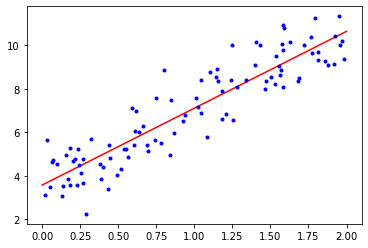

In [9]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)

plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")

This also works with scikit-learn

In [10]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([3.57786577]), array([[3.52921164]]))

In [11]:
lin_reg.predict(X_new)

array([[ 3.57786577],
       [10.63628904]])

This is based on np.linalg.lstsq()

In [14]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[3.57786577],
       [3.52921164]])

This computes $\hat \theta = X^{+}y$, $X^{+}$ = [pseudoinverse](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse) of X. This is calculated using *Singular Value Decomposition (SVD)* (`np.linalg.svd()`). 

The actual matrix may not be invertible, but the pseudoinverse is always defined. 

**Computational complexity**

SVD is about O(n^2) (number of features) and O(m) (number of samples). 

## Gradient Descent

note: I'm already fairly familiar with the so just getting the jist. 

general idea: pass some inputs through the model, compute a cost function (normally we want to minimize this). This cost function is naturally also a function of the weights of the model, so compute the gradient of the cost function with respect to each of the weights. Then modify the weights according to that gradient. 

analogy: lost in the mountains in the fog. A good strategy to get down is to feel the slope below your feet and walk in the steepest direction downward. 

challenges: determining whether you're in a global minimum, local minimum, or a plateau. 

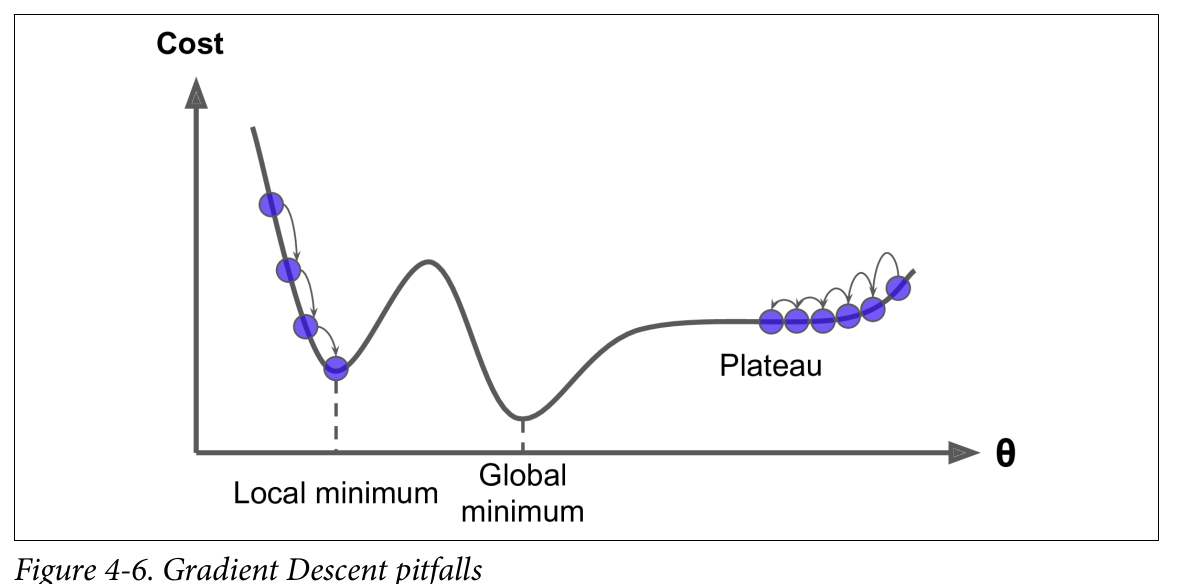

Also, function may be elongated if the features are not scaled equally 

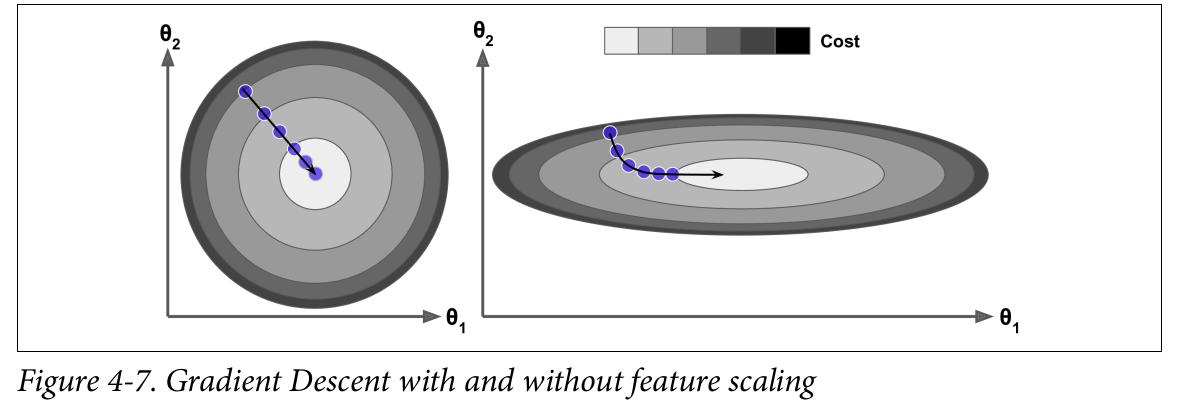


ANY TIME YOU USE GRADIENT DESCENT THE FEATURES MUST BE SCALED EQUALLY

**Batch gradient descent**

for linear regression, you can calculate the derivative of all parameters with the entire training set in one go: 

$$
\nabla_{\theta} MSE(\theta) = \frac{2}{m} X^{T} (X\theta - y)
$$

scales well with number of features

note: you can implement a tolerance $\epsilon$ to cut off the algo when the gradient vector gets small

**Stochastic Gradient Descent**

Pick random samples from the training set one at a time and do gradient descent each time. 

inherently random, so may not find the true optimization

may allow escape from local minima

*learning schedule* - gradually lower the learning rate so that the cost function remains closer to the minimum

Note: training instances must be IID (independent and identically distributed)

in sklearn: `sklearn.linear_model.SGDRegressor()`

**Mini-batch gradient descent**

like SGD, but uses several samples at once

## Polynomial Regression

add n-degree terms to a linear model including the combination<br>
linear: x1, x2<br>
quadratic: x1, x1^2, x2, x2^2, x1*x2

# Learning Curves

Train the model on several differently sized subsets of the training set and plot the cost function

Underfitting model (using a linear model to fit quadratic data)
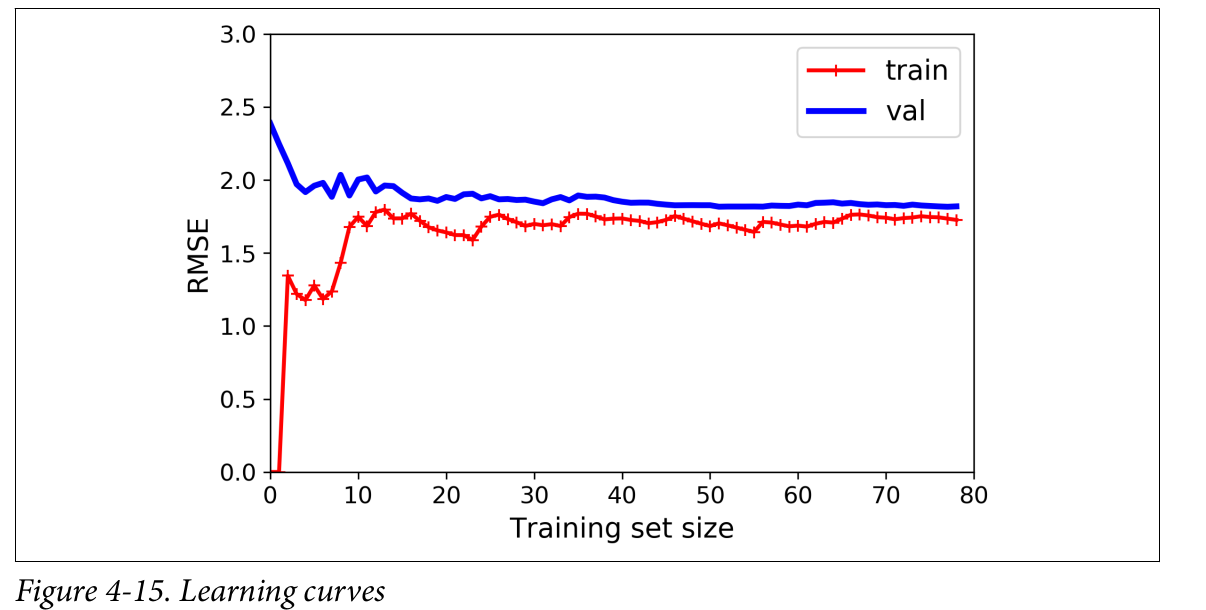

overfitting model (using a 10th-degree polynomial to fit quadratic data)
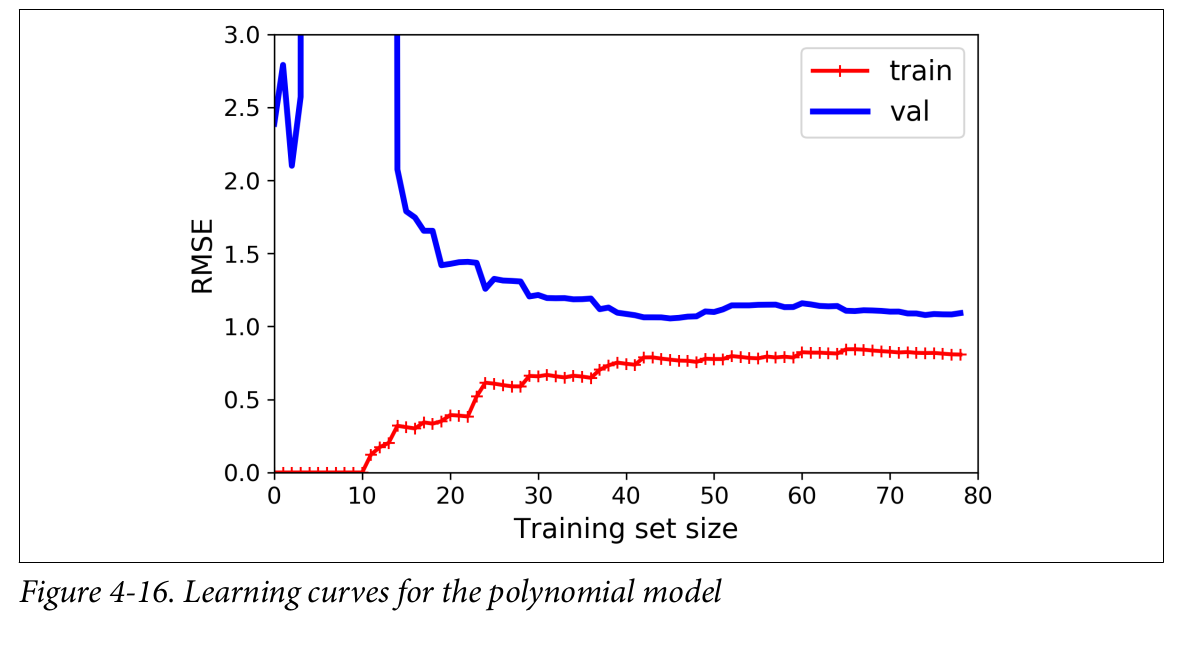


### Bias / variance tradeoff

generalization error = sum of 3 different errors:

1) Bias - wrong assumptions (high bias model may underfit) 
2) variance - sensitivity to small variations in training data (due to many degrees of freedom)
3) irreducible error - noice of the data itself


increasing complexity: decrease bias, increase variance<br>
reducing complexity: increase bias, decrease variance

## Regularized linear models

- Ridge Regression (l2) - add $\alpha \sum_{i=1}^{n}{\theta}_i^2$ to cost function (penalize large weights) (bias term is not added)
- Lasso Regression (l1) - add $\alpha \sum_{i=1}^{n} |\theta_i|$ to cost function. This can completely eliminate weights of unimportant features. In a way, it can automatically perform feature selection. 
- Elastic net (combo of l1 and l2)

In general, try ridge, then lasso or elastic net

# Early stopping

Train until the validation error reaches a minimum. When the val error starts going up, roll back the model to the point where the val error was minimized. 

Early stopping implementation in sklearn:

In [9]:
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

X_train = 6*np.random.rand(80, 1) - 3
X_val = 6*np.random.rand(20, 1) - 3
y_train = 0.5 * X_train**2 + X_train + 2 + np.random.randn(80, 1)
y_val = 0.5 * X_val**2 + X_val + 2 + np.random.randn(20, 1)


# prepare the data
poly_scaler = Pipeline([
  ('poly_features', PolynomialFeatures(degree=90, include_bias=False)),
  ('std_scaler', StandardScaler())
])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True, penalty=None,
                        learning_rate='constant', eta0=0.0005)

minimum_val_error = float("inf")

best_epoch = None
best_model = None

for epoch in range(1000):
  sgd_reg.fit(X_train_poly_scaled, y_train.flatten()) # continues where it left off
  
  y_val_predict = sgd_reg.predict(X_val_poly_scaled)
  val_error = mean_squared_error(y_val, y_val_predict)
  
  if val_error < minimum_val_error:
    minimum_val_error = val_error
    best_epoch = epoch
    best_model = clone(sgd_reg)

warm starting in pytorch: https://pytorch.org/tutorials/recipes/recipes/warmstarting_model_using_parameters_from_a_different_model.html

In [10]:
best_model

SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
             tol=-inf, warm_start=True)

## Logistic Regression